# Normalize for continuous (=spatial) features

- We define the min-max cutoffs for the min-max normalization of continuous features such as the distances and moments features: Use the floor/ceiling values of the minimum/maximum values of the distances w.r.t. to each subpocket center.
- Investigate other normalization schemes including min-max normalization per residue position and z-scores.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Markdown

from kissim.encoding import FingerprintGenerator

In [2]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results/all"

## Min-max normalization over all residues

### Load fingerprints

In [3]:
fingerprint_generator = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")
# NBVAL_CHECK_OUTPUT

Number of fingerprints: 4623


### Distances features

In [4]:
features_d = fingerprint_generator.distances_exploded()
features_d

hinge_region  dfg_region  front_pocket  \
structure_klifs_id residue_ix                                           
1                  1              13.453884   18.280884     14.480577   
                   2              12.553288   15.885122     12.370021   
                   3              10.540322   14.686474      9.160533   
                   4              10.875768   12.470337      8.180632   
                   5              13.355084   12.179722     10.597742   
...                                     ...         ...           ...   
13740              81              8.176181    6.305268      6.473903   
                   82             10.908327    6.283243     10.256677   
                   83             12.301838    4.710865     10.973125   
                   84             15.421875    8.506138     13.081077   
                   85             15.769991    9.725726     14.484319   

                                  center  
structure_klifs_id residue_ix             
1                  1           17.260859  
                   2           15.571550  
                   3           13.120049  
                   4           12.173719  
                   5           13.909365  
...                                  ...  
13740              81           2.834086  
                   82           5.545019  
                   83           7.593192  
                   84          10.190306  
                   85          10.333244  

[392955 rows x 4 columns]

In [5]:
features_d_stats = features_d.describe(percentiles=[0.001, 0.01, 0.99, 0.999])
features_d_stats

,hinge_region,dfg_region,front_pocket,center
count,387959.000000,385252.000000,387959.000000,387959.000000
mean,12.869833,13.555590,13.026229,11.998166
std,4.561533,4.853862,4.284138,3.475858
min,2.373261,0.873535,1.355564,1.001008
0.1%,3.709586,3.603832,4.556187,2.321407
1%,4.109286,4.647196,5.453499,3.054746
50%,12.566377,13.282713,12.446102,12.010692
99%,23.059747,26.692551,23.435605,21.187462
99.9%,24.982803,29.178193,25.909915,23.414564
max,30.791023,33.577599,33.154510,26.890888


In [6]:
features_d_stats.loc[["min", "max"], :]

,hinge_region,dfg_region,front_pocket,center
min,2.373261,0.873535,1.355564,1.001008
max,30.791023,33.577599,33.154510,26.890888


In [7]:
distance_cutoff = pd.concat(
    [np.floor(features_d_stats.loc["min", :]), np.ceil(features_d_stats.loc["max", :])], axis=1
).transpose()
distance_cutoff

,hinge_region,dfg_region,front_pocket,center
min,2.0,0.0,1.0,1.0
max,31.0,34.0,34.0,27.0


Format as dictionary as needed for `kissim`: 
https://github.com/volkamerlab/kissim/blob/master/kissim/definitions.py

In [8]:
{subpocket_name: tuple(values) for subpocket_name, values in distance_cutoff.items()}

{'hinge_region': (2.0, 31.0),
 'dfg_region': (0.0, 34.0),
 'front_pocket': (1.0, 34.0),
 'center': (1.0, 27.0)}

### Moments features

In [9]:
features_m = fingerprint_generator.moments_exploded()
features_m = features_m.stack().unstack(level=1).reset_index(drop=True)

In [10]:
features_m_stats = features_m.describe(percentiles=[0.001, 0.01, 0.99, 0.999])
features_m_stats

moment,1,2,3
count,18459.000000,18459.000000,18459.000000
mean,12.861647,4.281208,2.797867
std,0.607657,0.553802,1.026829
min,11.471416,2.876950,-2.292876
0.1%,11.580878,3.059642,-2.086442
1%,11.681313,3.263421,-1.616604
50%,12.918043,4.422983,2.881529
99%,14.148403,5.246327,4.659015
99.9%,14.650755,5.513392,5.630815
max,16.848968,6.190806,6.064899


In [11]:
moment_cutoff = pd.concat(
    [np.floor(features_m_stats.loc["min", :]), np.ceil(features_m_stats.loc["max", :])], axis=1
).transpose()
moment_cutoff

moment,1,2,3
min,11.0,2.0,-3.0
max,17.0,7.0,7.0


Format as dictionary as needed for `kissim`: 
https://github.com/volkamerlab/kissim/blob/master/kissim/definitions.py

In [12]:
{subpocket_name: tuple(values) for subpocket_name, values in moment_cutoff.items()}

{1: (11.0, 17.0), 2: (2.0, 7.0), 3: (-3.0, 7.0)}

## Different normalization schemes for distances features

### Define functions

In [13]:
def plot_unnormalized_distances(fps):
    for subpocket_name, values in fps.distances_exploded().iteritems():
        residue_distribution = values.unstack()
        residue_distribution.plot(kind="box", figsize=(15, 3), title=subpocket_name)
    
def plot_unnormalized_moments(fps):
    residue_distribution = fps.moments_exploded().unstack()
    residue_distribution.plot(kind="box", figsize=(15, 3))

In [14]:
def plot_normalized_distances_min_max_all_positions(fps):
    for subpocket_name, values in fps.distances_exploded().iteritems():
        residue_distribution = values.unstack()
        residue_distribution.plot(kind="box", figsize=(15, 3), title=subpocket_name)
    
def plot_normalized_moments_min_max_all_positions(fps):
    residue_distribution = fps.moments_exploded().unstack()
    residue_distribution.plot(kind="box", figsize=(15, 3))

In [15]:
def min_max_normalize(X):
    scaler = MinMaxScaler()
    X = X.to_frame()
    scaler.fit(X)
    XX = scaler.transform(X)
    XX = pd.DataFrame(XX, index=X.index)
    return XX

In [16]:
def plot_normalized_distances_z_scale(fps):
    for subpocket_name, values in fps.distances_exploded().iteritems():
        residue_distribution = values.unstack()
        residue_distribution_z_scale = residue_distribution.apply(lambda x: zscore(x, nan_policy='omit'), axis=0)
        residue_distribution_z_scale.plot(kind="box", figsize=(15, 3), title=subpocket_name)
    
def plot_normalized_moments_z_scale(fps):
    residue_distribution = fps.moments_exploded().unstack()
    residue_distribution_z_scale = residue_distribution.apply(lambda x: zscore(x, nan_policy='omit'), axis=0)
    residue_distribution_z_scale.plot(kind="box", figsize=(15, 3))

In [17]:
def plot_normalized_distances_min_max_per_position(fps):
    residue_distribution_max_min_per_residue_summary = {}
    for subpocket_name, values in fps.distances_exploded().iteritems():
        residue_distribution = values.unstack()
        residue_distribution_max_min_per_residue = []
        for index, column in residue_distribution.iteritems():
            residue_distribution_max_min_per_residue.append(min_max_normalize(column))
        residue_distribution_max_min_per_residue = pd.concat(residue_distribution_max_min_per_residue, axis=1)
        residue_distribution_max_min_per_residue.columns = residue_distribution.columns
        residue_distribution_max_min_per_residue.plot(kind="box", figsize=(15, 3), title=subpocket_name)
        residue_distribution_max_min_per_residue_summary[subpocket_name] = residue_distribution_max_min_per_residue
    return residue_distribution_max_min_per_residue_summary
    
    
def plot_normalized_moments_min_max_per_position(fps):
    residue_distribution = fps.moments_exploded().unstack()
    residue_distribution_max_min_per_residue = []
    for index, column in residue_distribution.iteritems():
        residue_distribution_max_min_per_residue.append(min_max_normalize(column))
    residue_distribution_max_min_per_residue = pd.concat(residue_distribution_max_min_per_residue, axis=1)
    residue_distribution_max_min_per_residue.columns = residue_distribution.columns
    residue_distribution_max_min_per_residue.plot(kind="box", figsize=(15, 3))
    return residue_distribution_max_min_per_residue

### Unnormalized fingerprints

In [18]:
fps = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")

#### Distances

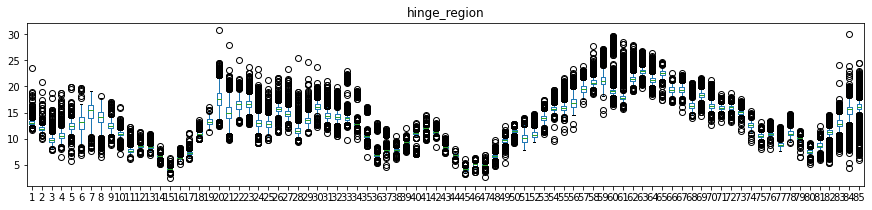

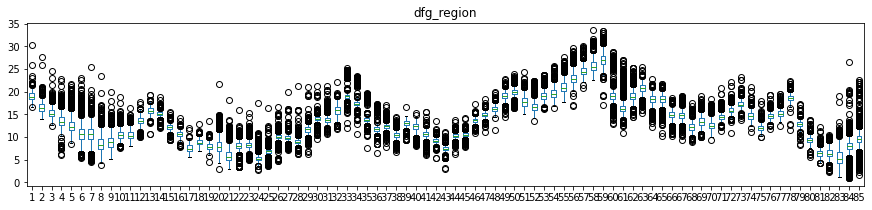

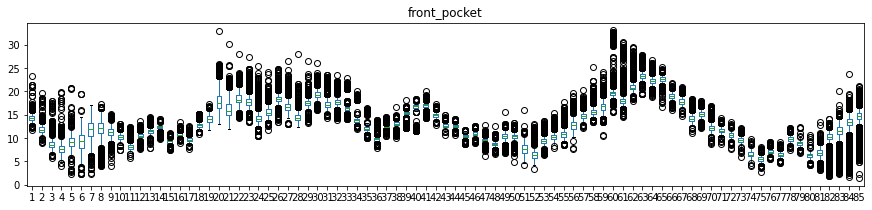

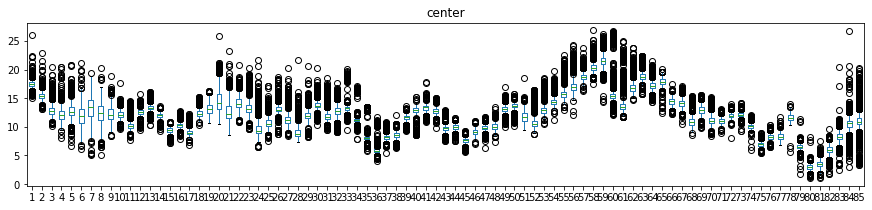

In [19]:
display(Markdown("#### Distances"))
plot_unnormalized_distances(fps)

#### Moments

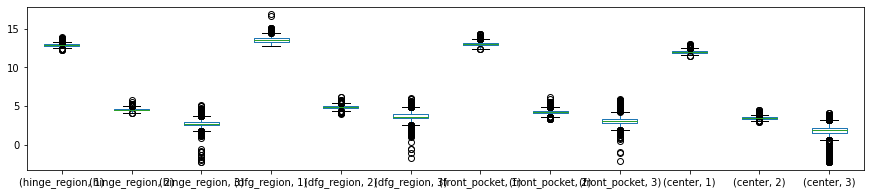

In [20]:
display(Markdown("#### Moments"))
plot_unnormalized_moments(fps)

### Normalized fingerprints: Min-Max over all residue positions

In [21]:
fps = FingerprintGenerator.from_json(RESULTS / "fingerprints_normalized.json")

#### Distances

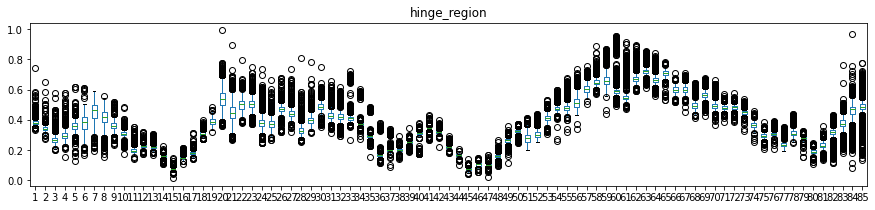

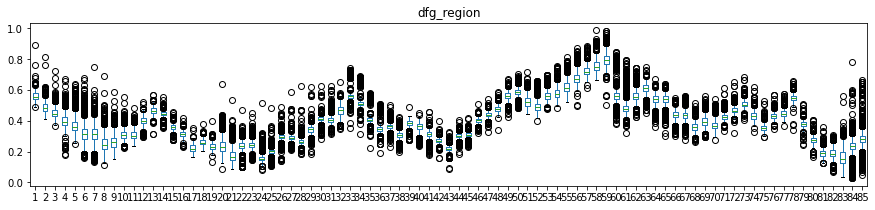

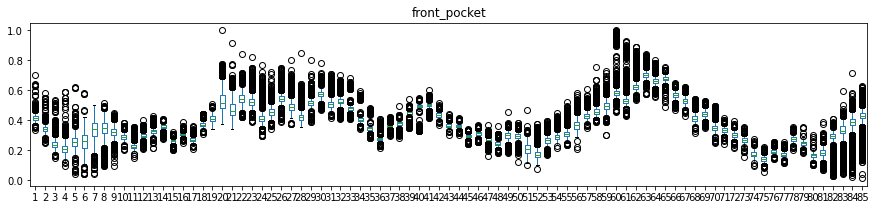

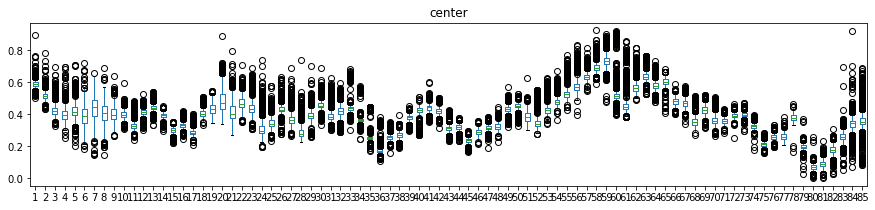

In [22]:
display(Markdown("#### Distances"))
plot_normalized_distances_min_max_all_positions(fps)

#### Moments

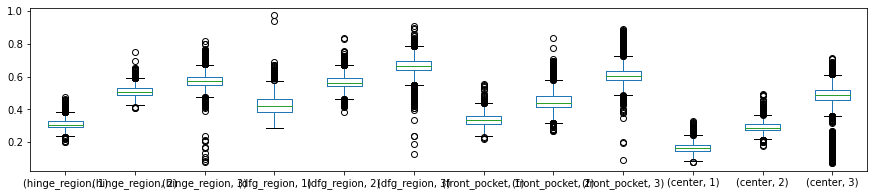

In [23]:
display(Markdown("#### Moments"))
plot_normalized_moments_min_max_all_positions(fps)

### Normalized fingerprints: z-score

In [24]:
fps = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")

#### Distances

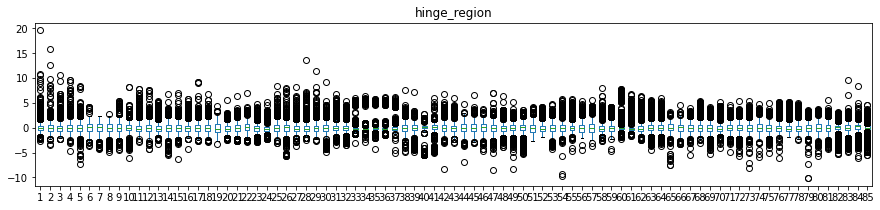

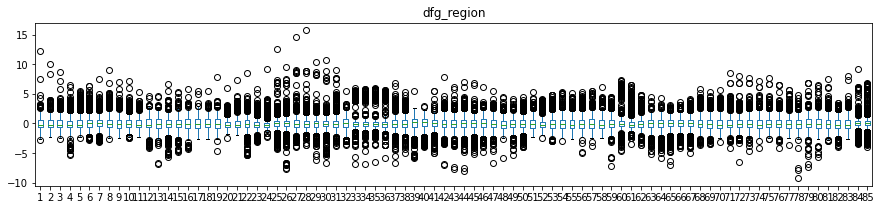

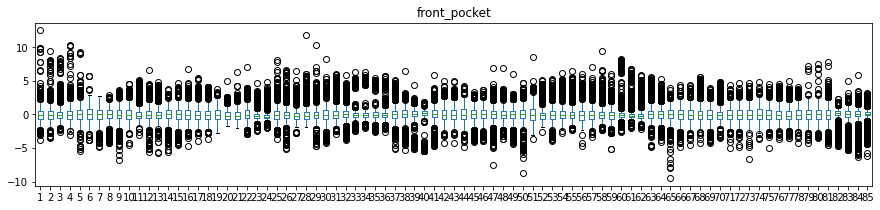

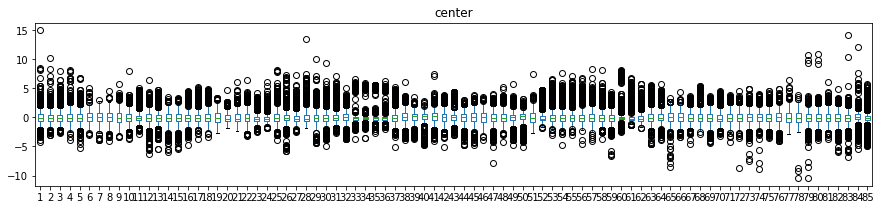

In [25]:
display(Markdown("#### Distances"))
plot_normalized_distances_z_scale(fps)

#### Moments

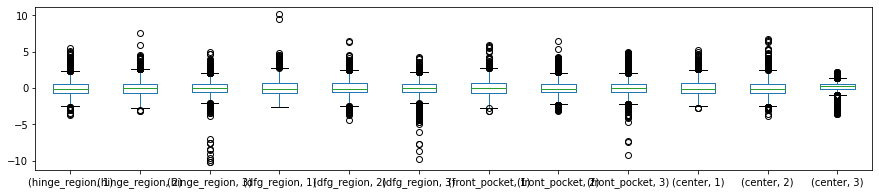

In [26]:
display(Markdown("#### Moments"))
plot_normalized_moments_z_scale(fps)

### Normalized fingerprints: Min-max per residue position

#### Distances

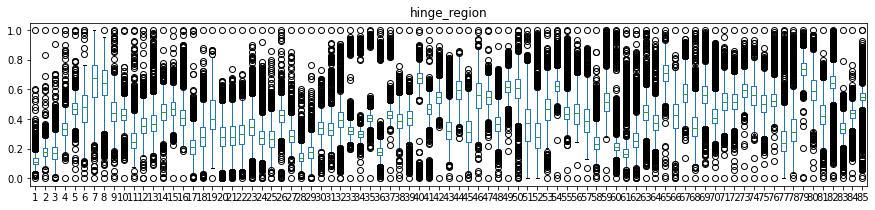

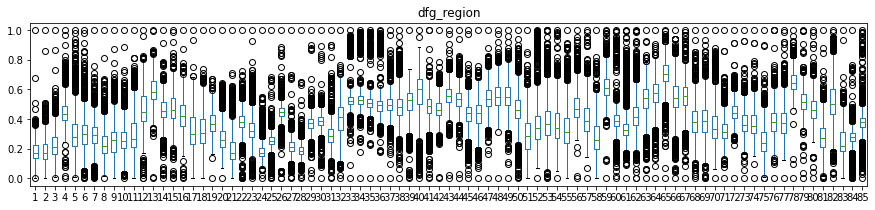

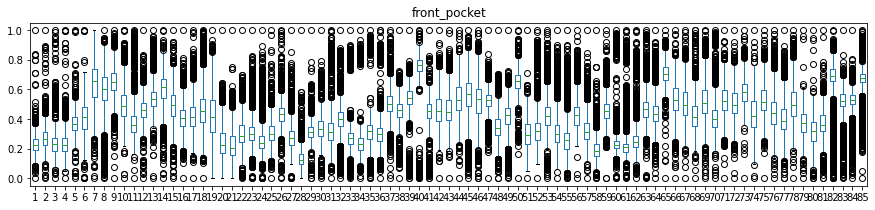

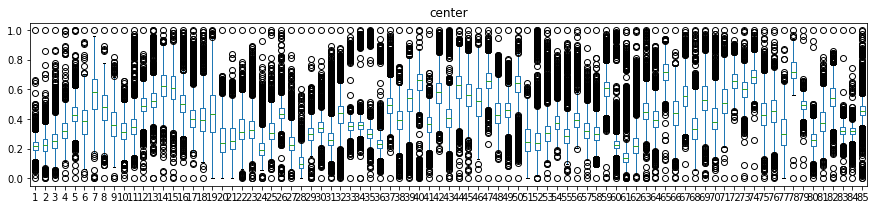

In [27]:
display(Markdown("#### Distances"))
normalized_distances_min_max_per_position = plot_normalized_distances_min_max_per_position(fps)

#### Moments

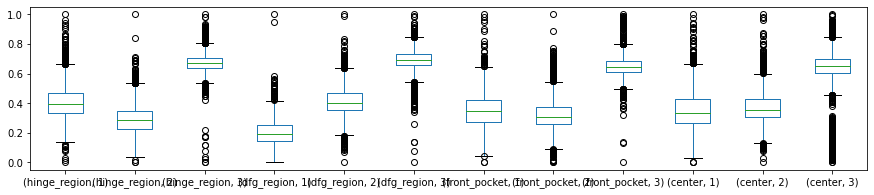

In [28]:
display(Markdown("#### Moments"))
normalized_moments_min_max_per_position = plot_normalized_moments_min_max_per_position(fps)

#### Calculate normalized fingerprint

In [29]:
fps = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")

# Physicochemical features
fps_normalized = FingerprintGenerator.from_json(RESULTS / "fingerprints_normalized.json")
for structure_id, fingerprint in fps.data.items():
    fingerprint.values_dict["physicochemical"] = fps_normalized.data[structure_id].values_dict["physicochemical"]
    
# Distances features
for subpocket_name, df in normalized_distances_min_max_per_position.items():
    for structure_id, distances in df.iterrows():
        fps.data[structure_id].values_dict["spatial"]["distances"][subpocket_name] = distances.to_list()
        
# Moments features
for structure_id, row in normalized_moments_min_max_per_position.iterrows():
    for subpocket_name, moments in row.unstack().iterrows():
        fps.data[structure_id].values_dict["spatial"]["moments"][subpocket_name] = moments.to_list()

<AxesSubplot:>

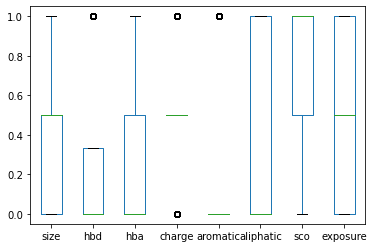

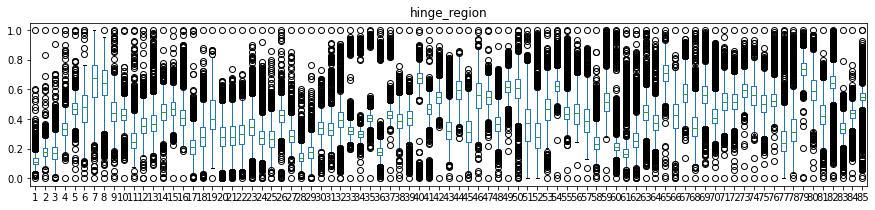

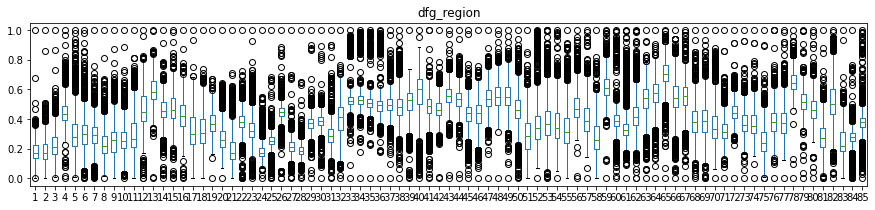

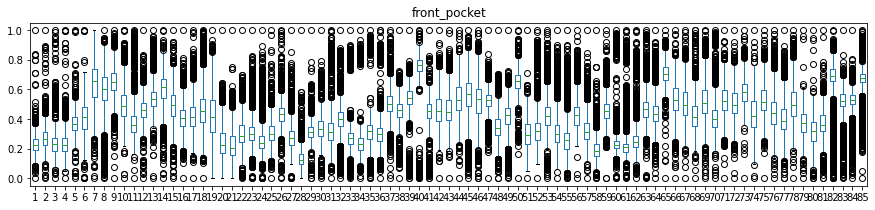

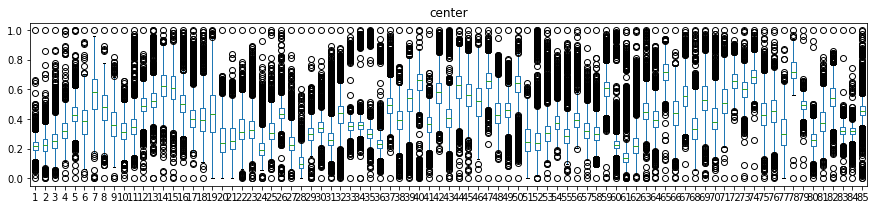

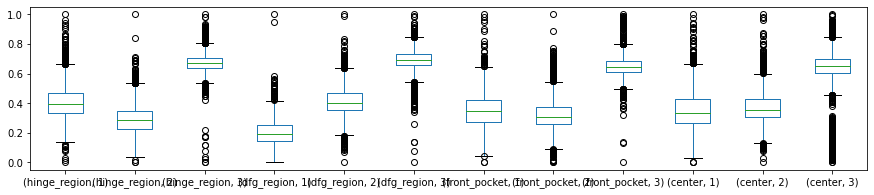

In [30]:
fps.physicochemical_exploded().plot(kind="box")
for subpocket_name, values in fps.distances_exploded().iteritems():
    residue_distribution = values.unstack()
    residue_distribution.plot(kind="box", figsize=(15, 3), title=subpocket_name)
fps.moments_exploded().unstack().plot(kind="box", figsize=(15, 3))